In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#!conda install -c pytorch pytorch 
#conda install pytorch torchvision cpuonly -c pytorch

In [1]:
#!pip install category_encoders
#!conda install torch
import pandas as pd
import numpy as np
import pickle
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import re
import torch 
import os
from IPython.display import Image, display, clear_output

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

import seaborn as sns

In [37]:
df = pd.read_pickle('C:/Users/niskl/Downloads/all_data.pkl')
df.info()
#df = df.sample(frac=1)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24990 entries, 0 to 24989
Columns: 1179 entries, AARSRAPPORT_html to sidstOpdateret
dtypes: float64(663), object(516)
memory usage: 224.8+ MB


(24990, 1179)

## Preprocessing

In [38]:
#Droping some columns

#We can try without dropping the same company in my runs it performed slightly 
# better if I dropped them
#df = df.drop_duplicates(subset='cvrNummer', keep="first")
df = df.drop(columns=['AARSRAPPORT_pdf', 
                      'AARSRAPPORT_html', 'AARSRAPPORT_xml','_score', 'entity', 
                      'cvrNummer',
                      'regnskabsperiode_startDato', 'sidstOpdateret', 
                      'sagsNummer', 'regnskabsperiode_slutDato', '_index', 'context', 
                      'end_date', 'offentliggoerelsesTidspunkt', 'indlaesningsTidspunkt',
                      'indlaesningsId', '_id', 'regNummer', 'AddressOfAuditorCountry', 'AddressOfAuditorCountryIdentificationCode',
                      'AddressOfAuditorDistrictName', 'AddressOfAuditorStreetBuildingIdentifier', 'AddressOfAuditorStreetName',
                      'AddressOfFinancialCountry', 'AddressOfFinancialCountryIdentificationCode', 'AddressOfFinancialDistrictName',
                      'AddressOfAuditorPostCodeIdentifier', 'AddressOfFinancialStreetBuildingIdentifier', 'AddressOfFinancialStreetName',
                      'AddressOfFinancialPostCodeIdentifier', 'AddressOfReportingEntityDistrictName', 'AddressOfReportingEntityStreetBuildingIdentifier',
                      'AddressOfReportingEntityStreetName', 'AddressOfSubmittingEnterprisePostcodeAndTown', 'AddressOfSubmittingEnterpriseStreetAndNumber',
                      'AddresseeOfAuditorsReportOnAuditedFinancialStatements', 'ConfirmationThatAnnualReportIsPresentedInAccordanceWithRequirementsProvidedForByLegislationAnyStandardsAndRequirementsProvidedByArticlesOfAssociationOrByAgreement',
                      'ConfirmationThatFinancialStatementGivesTrueAndFairViewOfAssetsLiabilitiesEquityFinancialPositionAndResults', 'DescriptionOfMethodsOfDividends',
                      'DescriptionOfMethodsOfRecognitionAndMeasurementBasisOfAssetsAndLiabilities', 'StatementByExecutiveAndSupervisoryBoards', 
                      'offentliggoerelsestype', 'omgoerelse', 'DescriptionOfAuditor', 'RegisteredOfficeOfReportingEntity',
                      'RecommendationForApprovalOfAnnualReportByGeneralMeeting','ManagementsStatementAboutManagementsReview', 'ManufacturedGoodsAndGoodsForResale',
                      'NameAndSurnameOfAuditor', 'PlaceOfSignatureOfStatement', 'ManagementsReview', 'NameAndSurnameOfChairmanOfGeneralMeeting',
                      'NameAndSurnameOfMemberOfExecutiveBoard', 'NameOfAuditFirm', 'NameOfFinancialInstitution', 'NameOfReportingEntity','NameOfSubmittingEnterprise',
                      'OpinionOnAuditedFinancialStatements', 'Goodwill', 
                      'TheCompanyHasPresentedTheAnnualReportEtcWithReferenceToTheDanishFinancialStatementsAct78aConcerningTheExceptionForReportingClassCMediumsizeSubsidiariesWhichChoosesToPresentTheAnnualReportEtcAccordingToReportingClassB',
                      'TheReportingEntityAppliesTheExceptionConcerningOptingOutOfTheStatementByManagementEtc'
                      ])
all_zeros = df.columns[df.notna().sum() == 0]
df = df.drop(columns=all_zeros)
df = df.loc[:,~df.columns.str.contains('^date', case=False)] 
df = df.loc[:,~df.columns.str.contains('^Telephone', case=False)] 
df = df.loc[:,~df.columns.str.contains('^Statement', case=False)] 
df = df.loc[:,~df.columns.str.contains('^TitleOf', case=False)] 
df = df.loc[:,~df.columns.str.contains('^DescriptionOf', case=False)] 
df = df.loc[:,~df.columns.str.contains('^DisclosureOf', case=False)] 
df = df.loc[:,~df.columns.str.contains('^EmailOf', case=False)] 
df = df.loc[:,~df.columns.str.contains('^InformationOn', case=False)] 
df = df.loc[:,~df.columns.str.contains('^SignatureOf', case=False)] 
df = df.loc[:,~df.columns.str.contains('^ReportingPeriod', case=False)] 
df = df.loc[:,~df.columns.str.contains('^Identification', case=False)] 

# Turn Company type into either A, B, C or D 
idx = list(df.ClassOfReportingEntity.index)
for loc, ent_type in enumerate(df.ClassOfReportingEntity):
  if len(re.findall('[ABCD]', str(ent_type))) == 0:
    df.ClassOfReportingEntity.loc[idx[loc]] = np.NaN
  else:
    df.ClassOfReportingEntity.loc[idx[loc]] = re.findall('[ABCD]', str(ent_type))[0]


#Drop companies with revenue less than 0
df = df[df.Target > 1]
df = df[df.Revenue > 1]
df = df[(df.Target==df.Target.astype(int))==True]
df = df[(df.Revenue==df.Revenue.astype(int))==True]

#Drop outliers???
differ = abs(df.Revenue-df.Target)
#q = differ.quantile(0.999)
df = df[differ < list(reversed(sorted(differ)))[2]]

print(df.shape)
df = df.reset_index()
df = df.drop(columns=['index'])



C:\Users\niskl\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(15721, 775)


In [4]:
#df = df.drop(['index'],axis=1) 3.69009e+07
#df.Target==int(df.Target)

#df = df[(df.CurrentAssets==df.CurrentAssets.astype(int))==True]
#print(df.shape)
#df.columns
#df.CurrentAssets
#sum(df.Equity==df.Equity.astype(int))
#differ = abs(df.Revenue-df.Target)
#list(reversed(sorted(differ)))

(15721, 775)


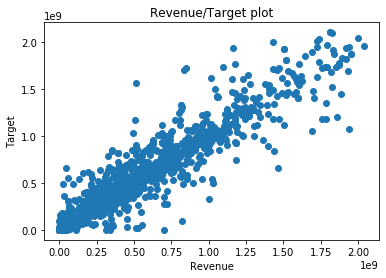

In [39]:
#df[df.Target == -1202364]['cvrNummer']
#df[df.cvrNummer==24238016]
#sum(df.Target==0)/len(df.Target)
print(df.shape)
plt.scatter(df["Revenue"],df["Target"])
plt.xlabel('Revenue') 
plt.ylabel('Target') 
plt.title('Revenue/Target plot')
plt.show()

In [6]:
#diff = abs(np.log10(df["Revenue"])-np.log10df["Target"])/()
#print(sorted(diff))
#df['difference']=diff
#print(sorted(diff)[0])
#maxdiff = list(reversed(sorted(diff)))[3]
#print(maxdiff)
#print(df.difference)
#print(test)
#print(df[df.difference==maxdiff].cvrNummer)
#print(df[df.difference==maxdiff].Target)
#print(df[df.difference==maxdiff].Revenue)

#outliers= ['35532595','32562361','87310116']

#print(df[df.difference==test].index)
#print("cvr")
#print(df.cvrNummer[14651:14653])
#print(df.cvrNummer[14652])
#print("rev/targ")
#print(saved_target[15533:15535])
#print(df.Revenue[14652],df.Target[14652])
#print(df.iloc[15534,:])

In [7]:
number_obs = df.shape[0]
col_to_drop = []
for col in df.columns:
  if df[col].isna().sum() / number_obs >= 0.9:
    col_to_drop.append(col)

print(f'Number of columns to drop {len(col_to_drop)} out of {df.shape[1]}')

#num_features = df._get_numeric_data().columns
#num_features_idc = [df.columns.get_loc(col) for col in df._get_numeric_data().columns]

#target_idx = df._get_numeric_data().columns.get_loc("Target")

Number of columns to drop 696 out of 775


In [8]:
df = df.drop(columns=col_to_drop)
df

,AccountingPoliciesAreUnchangedFromPreviousPeriod,AddressOfReportingEntityPostCodeIdentifier,AdjustmentsForDeferredTax,AdministrativeExpenses,Assets,AverageNumberOfEmployees,CashAndCashEquivalents,ClassOfReportingEntity,ContributedCapital,CostOfProduction,...,ShorttermTaxPayables,ShorttermTaxReceivables,ShorttermTradePayables,ShorttermTradeReceivables,SocialSecurityContributions,Target,TaxExpense,TaxExpenseOnOrdinaryActivities,TypeOfAuditorAssistance,WagesAndSalaries
0,NaN,5900,NaN,258164.0,2507086.0,NaN,342316.0,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,452653.0,NaN,NaN,"(Andre erklÃ¦ringer uden sikkerhed,)",NaN
1,NaN,4720,-43000.0,NaN,66203000.0,1.0,1410000.0,B,200000.0,NaN,...,205000.0,0.0,NaN,NaN,NaN,132998.0,-120000.0,NaN,"(RevisionspÃ¥tegning,)",78000.0
2,NaN,2300,12174.0,NaN,12732542.0,35.0,656896.0,B,500000.0,NaN,...,NaN,298476.0,1036270.0,1748924.0,109036.0,28581998.0,834952.0,834952.0,"(ErklÃ¦ring om udvidet gennemgang,)",17824519.0
3,True,3670,NaN,NaN,NaN,1.0,NaN,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,41572.0,8778.0,NaN,"(Andre erklÃ¦ringer uden sikkerhed,)",NaN
4,False,4100,NaN,NaN,NaN,136.0,NaN,C,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,266900000.0,NaN,NaN,"(RevisionspÃ¥tegning,)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15716,NaN,9240,NaN,NaN,1464266.0,NaN,NaN,B,125000.0,NaN,...,0.0,NaN,3750.0,NaN,NaN,324414.0,-825.0,NaN,"(ErklÃ¦ring om udvidet gennemgang,)",NaN
15717,True,8752,-251270.0,NaN,1119252.0,2.0,128747.0,B,125000.0,NaN,...,NaN,3719.0,94691.0,NaN,19256.0,4868.0,-254233.0,-254233.0,"(RevisionspÃ¥tegning,)",425311.0
15718,True,4300,NaN,NaN,NaN,NaN,NaN,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,163500.0,40876.0,NaN,"(Ingen bistand,)",NaN
15719,NaN,4840,NaN,365982.0,7658364.0,NaN,307678.0,B,6700000.0,442814.0,...,0.0,NaN,17168.0,1710.0,NaN,664906.0,28949.0,NaN,"(RevisionspÃ¥tegning,)",NaN


In [26]:
#testing
df = df[['Assets','CurrentAssets','ProfitLoss','Revenue','Target']]
df = df._get_numeric_data().fillna(0)
df
#df.dropna()

,Assets,CurrentAssets,ProfitLoss,Revenue,Target
0,2507086.0,0.0,2.556240e+05,573079.0,452653.0
1,66203000.0,55366000.0,-5.115000e+05,133000.0,132998.0
2,12732542.0,11678705.0,1.897379e+06,36398986.0,28581998.0
3,0.0,0.0,3.062700e+04,88971.0,41572.0
4,0.0,0.0,-4.800000e+06,226500000.0,266900000.0
...,...,...,...,...,...
15716,1464266.0,492576.0,4.468500e+03,11863.0,324414.0
15717,1119252.0,209305.0,-1.030795e+06,286050.0,4868.0
15718,0.0,0.0,1.343510e+05,204555.0,163500.0
15719,7658364.0,1415790.0,5.198750e+04,669696.0,664906.0


In [30]:
validation_split = .2
test_split = .1
shuffle_dataset = True
chosen_seed = np.random.randint(0, 1000000)
random_seed= chosen_seed

# Creating data indices for training and validation splits:
dataset_size = len(df)
indices = list(range(dataset_size))
split_val = int(np.floor(validation_split * dataset_size))
split_test = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices,test_indices = indices[split_val:], indices[split_test:split_val], indices[:split_test]

train_df, val_df, test_df = df.iloc[train_indices,:], df.iloc[val_indices,:], df.iloc[test_indices,:] 

#keep test target to evaluate rescaling
test_target = test_df.Target.values

train_df.shape, val_df.shape

((12577, 5), (1572, 5))

In [12]:
obj_df = df.select_dtypes(include=['object'])
obj_df

""
0
1
2
3
4
...
15716
15717
15718
15719


In [36]:
num_df = df._get_numeric_data().fillna(0)
#num_df.hist(figsize=(30,30), bins = 50, log=True)
train_df

,Assets,CurrentAssets,ProfitLoss,Revenue,Target
13012,153343184.0,1071456.0,2.291483e+06,7514792.0,7669583.0
8468,1833946.0,1650.0,2.416300e+05,490410.0,1445053.0
2358,0.0,0.0,7.064390e+05,79782.0,159815.0
4194,0.0,0.0,1.351060e+05,2594149.0,2594149.0
13588,80594000.0,57886000.0,-5.996571e+06,148621000.0,179342000.0
...,...,...,...,...,...
3847,16712549.0,8382549.0,2.924000e+03,166600.0,166600.0
11381,405500.0,405500.0,-1.240160e+05,300460.0,21090.0
2921,0.0,0.0,1.481140e+05,1528481.0,1389666.0
10022,24513771.0,26979.0,-1.794086e+06,2627925.0,2773810.0


In [436]:
encoder = ce.target_encoder.TargetEncoder(verbose=1)
#encoder = ce.one_hot.OneHotEncoder()
#X_scaler = MinMaxScaler()
#y_scaler = MinMaxScaler()
X_scaler = StandardScaler()
y_scaler = StandardScaler()

def preprocessing(df, encoder, X_scaler, y_scaler, train=True):

    #separate numerical from categorical columns
    obj_df = df.select_dtypes(include=['object'])

    # Could try to use a random variable (0, 1) instead of zero after scaling
    num_df = df._get_numeric_data().fillna(0) #also filling nans in numerical columns with zeros???
    targets = num_df.Target.to_numpy().reshape(-1,1)
    #there are several other that we could use in this module, or do something ourselves
    if train:
      #fit encoder and scaler
      X_scaler = X_scaler.fit(num_df.drop('Target', axis=1).to_numpy())
      y_scaler = y_scaler.fit(num_df.Target.to_numpy().reshape(-1,1))
      encoder.fit(obj_df,  y_scaler.transform(targets))


    #encode categorical attributes
    obj_df = encoder.transform(obj_df)
  


    #scale the numerical attributes
    X_scaled = X_scaler.transform(num_df.drop('Target', axis=1).to_numpy())

    num_df = num_df.drop('Target', axis=1)
    num_cols = []
    num_cols.extend(list(num_df.columns))
    num_cols.extend(list(obj_df.columns))
    num_cols.extend(['Target'])
    X_scaled = np.hstack((X_scaled, obj_df.to_numpy()))
    X_scaled = np.hstack((X_scaled, y_scaler.transform(targets) ))
    num_df = X_scaled



    # merge the two dataframes
    df = pd.DataFrame(data=X_scaled, columns=num_cols)
   # df[num_df.columns] = num_df
   # df[obj_df.columns] = obj_df

    return df, encoder, X_scaler, y_scaler

In [437]:
train_df, encoder, X_scaler, y_scaler = preprocessing(train_df, encoder, X_scaler, y_scaler , train=True)
val_df, _, _, _ = preprocessing(val_df, encoder, X_scaler, y_scaler , train=False)
test_df, _, _, _= preprocessing(test_df, encoder, X_scaler, y_scaler , train=False)


In [438]:
#train_df.to_csv('drive/My Drive/Valid_Data/processed_train_dat.csv')
#val_df.to_csv('drive/My Drive/Valid_Data/processed_val_dat.csv')

In [439]:
#X_scaler_train = X_scaler.fit(train_df)

#X_scaled_vals = X_scaler_train.transform(train_df.values)
#train_df_tmp = pd.DataFrame(X_scaled_vals, columns=train_df.columns)
#train_df_tmp.head()

#X_scaled_vals = X_scaler_train.transform(val_df.values)
#val_df_tmp = pd.DataFrame(X_scaled_vals, columns=val_df.columns)
#val_df_tmp.head()

#X_scaled_vals = X_scaler_train.transform(test_df.values)
#test_df_tmp = pd.DataFrame(X_scaled_vals, columns=val_df.columns)
#test_df_tmp.head()


## Dataset and DataLoaders

In [14]:
class Dataset(Dataset):
    
    def __init__(self, dataframe):
        
        self.data = dataframe
        self.X = torch.from_numpy(dataframe.drop('Target', axis=1).to_numpy('float32'))
        self.y = torch.from_numpy(dataframe.Target.to_numpy('float32'))
        
    def __len__(self):
        return len(self.data)
    
    def nb_features(self):
        return self.X.shape[1]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.X[idx] ,self.y[idx]
        
        return sample

In [31]:
batch_size = 64

train_dataset = Dataset(train_df)
validation_dataset = Dataset(val_df)
test_dataset = Dataset(test_df)

# Creating PT data samplers and loaders:
#train_sampler = SubsetRandomSampler(train_indices)
#valid_sampler = SubsetRandomSampler(val_indices)
#test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## Neural Network

A simple feedforward network to begin with!

In [16]:
class NN2(nn.Module):
    def __init__(self, input_dim, layers_dim, activations):
        
        super(NN2, self).__init__()
        
        layers = []

        for i in range(len(layers_dim)-1):
          
          # Use input dimensions here first
          if i == 0:
            layers.append(nn.Linear(input_dim, layers_dim[i]))
#           layers.append(nn.BatchNorm1d(layers_dim[0]))
            if activations[0] == 'relu':
              layers.append(nn.ReLU())
            elif activations[0] == 'elu':
              layers.append(nn.ELU())
            elif activations[0] == 'leaky':
              layers.append(nn.LeakyReLU())
            elif activations[0] == 'tanh':
              layers.append(nn.Tanh())
          else:
            layers.append(nn.Linear(layers_dim[i-1], layers_dim[i]))
#           layers.append(nn.BatchNorm1d(layers_dim[i]))
            if activations[i] == 'relu':
              layers.append(nn.ReLU())
            elif activations[i] == 'elu':
              layers.append(nn.ELU())
            elif activations[i] == 'leaky':
              layers.append(nn.LeakyReLU())
            elif activations[i] == 'tanh':
              layers.append(nn.Tanh())
          layers.append(nn.Dropout(p=0.3))

        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))
#        if activations[-1] == 'relu':
#          layers.append(nn.ReLU())
#        elif activations[-1] == 'elu':
##          layers.append(nn.ELU())
#        elif activations[-1] == 'leaky':
#          layers.append(nn.LeakyReLU())
#        elif activations[-1] == 'tanh':
#          layers.append(nn.Tanh())

        self.out = nn.Sequential(*layers)


    def forward(self, x):
            
        return self.out(x)

def weight_init(m):
  if isinstance(m, nn.Linear):
      nn.init.kaiming_normal_(m.weight)

In [17]:
class NN(nn.Module):
    def __init__(self, input_dim):
        
        super(NN, self).__init__()
        
        self.l1 = nn.Linear(input_dim, 512)
        
        self.l2 = nn.Linear(512, 256)
        
        self.l3 = nn.Linear(256, 64)
        
        self.out = nn.Linear(64, 1)


    def forward(self, x):
        
        x = F.dropout(F.relu(self.l1(x)),0.3,training=self.training)
        
        x = F.dropout(F.relu(self.l2(x)),0.3,training=self.training)
        
        x = F.dropout(F.relu(self.l3(x)),0.3,training=self.training)

        x = self.out(x)
        
        return x

def weight_init(m):
    if isinstance(m, nn.Linear):
        (nn.init.kaiming_normal_(m.weight))

In [18]:
def train(model):
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0
  
    for x, target in train_loader:

        target = target.to(device)
        x = x.to(device)
        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        ouput = model(x)
            
        loss = criterion(ouput, target)

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [19]:
def validate(model):
    # set the evaluation mode
    model.eval()

    # test loss for the data
    valid_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for x, target in val_loader:
            # reshape the data
            x = x.to(device)
            target = target.to(device)

            # forward pass
            output = model(x)

            # loss
            loss = criterion(output, target)
            valid_loss += loss.item()

    return valid_loss

In [20]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for x, target in test_loader:
            # reshape the data
            x = x.to(device)
            target = target.to(device)

            # forward pass
            output = model(x)

            # loss
            loss = criterion(output, target)
            test_loss += loss.item()

    return test_loss

In [447]:
input_dim = train_dataset.nb_features()
N_EPOCHS = 50
layers = [512, 256, 64, 1]
act_funs = ['leaky'] * len(layers)
model = NN2(input_dim, layers, act_funs)
optimizer = optim.Adam(model.parameters(),lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.modules.loss.MSELoss()

In [448]:
print(model)

NN2(
  (out): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [449]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score#

# Make predictions and get the targets
#predictions = model(test_dataset[:][0].to(device)).cpu().detach().numpy()
#target = test_dataset[:][1].to(device).cpu().detach().numpy()

# Transform back into scale
#unscaled_predictions = y_scaler.inverse_transform(predictions)
#unscaled_target = y_scaler.inverse_transform(target.reshape(-1,1))

In [21]:
def train_and_eval(model):
    old_loss = train(model)
    for e in range(N_EPOCHS):
        new_loss = train(model)
        if(old_loss-new_loss<0.00001):
            return(validate(model))
    return(validate(model))

In [35]:
# test = ['relu','elu','relu','leaky','tanh','tanh']
train_df
# print(test)
# for i in range(0,len(test)):
#     if(np.random.uniform()<0.2):#change 1 to mut_range
#       actv_func = test[i]
#       new_acvt_func = np.random.choice([x for x in options_act if x != actv_func],size=1)
#       print(new_acvt_func)
#       test[i] = new_acvt_func[0]
# print(test)
#test = ['leaky', 'elu', 'relu', 'leaky', 'tanh', 'tanh']
#test2 = ['relu', 'elu', 'relu', 'leaky', 'tanh', 'tanh']
#print(test==test2 and test==test)
#print(np.random.uniform()>0.5 and len([128, 32, 128, 16, 32, 64, 64, 64, 256, 256, 64, 1])>min_lay)

,Assets,CurrentAssets,ProfitLoss,Revenue,Target
13012,153343184.0,1071456.0,2.291483e+06,7514792.0,7669583.0
8468,1833946.0,1650.0,2.416300e+05,490410.0,1445053.0
2358,0.0,0.0,7.064390e+05,79782.0,159815.0
4194,0.0,0.0,1.351060e+05,2594149.0,2594149.0
13588,80594000.0,57886000.0,-5.996571e+06,148621000.0,179342000.0
...,...,...,...,...,...
3847,16712549.0,8382549.0,2.924000e+03,166600.0,166600.0
11381,405500.0,405500.0,-1.240160e+05,300460.0,21090.0
2921,0.0,0.0,1.481140e+05,1528481.0,1389666.0
10022,24513771.0,26979.0,-1.794086e+06,2627925.0,2773810.0


In [452]:
import copy
mut_rate = 0.1
mix_lay = 4
max_lay = 20
min_neuron = 8
max_neuron = 8192
options_act = ['relu','elu','leaky','tanh']
def child_create(par_net_var,mut_rate,i):
    child_net_var = copy.deepcopy(par_net_var)
    #Mutate number of layers
    if(np.random.uniform()<mut_rate*2):#add or remove a new layer with mut_rate chance
        num_layer_change = 1
        chance_var = np.random.uniform()
        if(chance_var<0.5 and len(child_net_var[0])<max_lay): #with 50% add a new layer
            inx_new_layer = np.random.randint(low=0,high=len(child_net_var[0])-1)
            new_layer_neurons = child_net_var[0][inx_new_layer]
            new_act = child_net_var[1][inx_new_layer]
            if(np.random.uniform()<0.5 and inx_new_layer!=0 ):
                new_layer_neurons = child_net_var[0][inx_new_layer-1]
                new_act = child_net_var[1][inx_new_layer]
            net_layer = []
            layer_actv = []
            net_layer.extend(child_net_var[0][:inx_new_layer])
            net_layer.append(new_layer_neurons)
            net_layer.extend(child_net_var[0][inx_new_layer:])
            layer_actv.extend(child_net_var[1][:inx_new_layer])
            layer_actv.append(new_act)
            layer_actv.extend(child_net_var[1][inx_new_layer:])
            child_net_var[0] = net_layer
            child_net_var[1] = layer_actv
        if(chance_var>0.5 and len(child_net_var[0])>min_lay): #with 50% remove an existing layer
            inx_del_layer = np.random.randint(low=0,high=len(child_net_var[0])-1)
            net_layer = []
            layer_actv = []
            net_layer.extend(child_net_var[0][:inx_del_layer])
            net_layer.extend(child_net_var[0][(inx_del_layer+1):])
            layer_actv.extend(child_net_var[1][:inx_del_layer])
            layer_actv.extend(child_net_var[1][(inx_del_layer+1):])
            child_net_var[0] = net_layer
            child_net_var[1] = layer_actv
    #Mutate number of neurons
    for i in range(0,len(child_net_var[0])-1):
        if(np.random.uniform()<mut_rate):
            neurons_in_layer = child_net_var[0][i]
            if(np.random.uniform()<0.5):
                neurons_in_layer = min(int(neurons_in_layer*2),max_neuron)
            else:
                neurons_in_layer = max(min_neuron,int(neurons_in_layer/2))
            child_net_var[0][i] = neurons_in_layer
    #Mutate activation functions
    for i in range(0,len(child_net_var[1])):
        if(np.random.uniform()<mut_rate):#change 1 to mut_range
            actv_func = child_net_var[1][i]
            new_acvt_func = np.random.choice([x for x in options_act if x != actv_func],size=1)
            child_net_var[1][i] = new_acvt_func[0]
    #Run again if nothing is changed
    if(child_net_var[0] == par_net_var[0] and child_net_var[1]==par_net_var[1] and i<20):
        child_net_var = child_create(par_net_var,mut_rate*1.1,i+1)
    return child_net_var 

def mutation(par_net_var,mut_rate):
    r1 = max(0.1,mut_rate/1.3)
    r2 = min(0.4,mut_rate*1.5)
    child1 = child_create(par_net_var,r1,0)
    child2 = child_create(par_net_var,r1,0)
    child3 = child_create(par_net_var,r2,0)
    child4 = child_create(par_net_var,r2,0)
    return child1,child2,child3,child4

def mutate_and_selection(par_net_var,par_score,mut_rate):
    children = mutation(par_net_var,mut_rate)
    child_scores = []
    for child in children:
        model = NN2(input_dim, child[0], child[1])
        model.to(device)
        child_scores.append(train_and_eval(model))
    best_child_score = min(child_scores)
    inx_best_child = child_scores.index(best_child_score)
    # if(len(best_child_score)>1):
    #   print("oh shit")
    mut_chance = np.random.uniform()
    if(mut_chance<0.25):
        mut_rate = max(0.1,mut_rate/1.3)
    elif(mut_chance<0.5):
        mut_rate=mut_rate = min(0.4,mut_rate*1.5)
    else:
        if(inx_best_child<3):
            mut_rate = max(0.1,mut_rate/1.3)
        else:
            mut_rate = min(0.4,mut_rate*1.5)
    model = NN2(input_dim, par_net_var[0], par_net_var[1])
    model.to(device)
    par_score = train_and_eval(model)
    if(best_child_score < par_score):
        par_score = child_scores[inx_best_child]
        par_net_var = children[inx_best_child]
        print(par_score)
        print(par_net_var)
    return par_net_var,par_score
  

In [453]:
par_net_var = []
layers = [512, 256,64 , 1]
 
par_net_var.append(layers)
act_funs = ['relu'] * len(layers)
par_net_var.append(act_funs)
model = NN2(input_dim, par_net_var[0], par_net_var[1])
model.apply(weight_init)
optimizer = optim.Adam(model.parameters())
model.to(device)

NN2(
  (out): Sequential(
    (0): Linear(in_features=4, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [28]:
input_dim = train_dataset.nb_features()
#layers = [2000, 1700, 800, 600, 500, 1000, 250, 900, 200, 100, 100, 100, 100, 100, 50, 25 , 1]
# layers = [512, 256, 128, 64, 1]
# act_funs = ['relu']*len(layers)
model = NN(input_dim)
model.apply(weight_init)
optimizer = optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.modules.loss.MSELoss()
print(model)

NN(
  (l1): Linear(in_features=4, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


In [32]:
N_EPOCHS = 20

train_history = []
val_history = []
model.train()

for e in range(N_EPOCHS):
  train_loss = train(model)
  val_loss = validate(model)
    #break
  train_loss /= len(train_indices)
  val_loss /= len(val_indices)
  if e%25 == 0:
        print(f'Epoch {e}, Train Loss: {train_loss:.4e}')
        print(f'Epoch {e}, Test Loss: {val_loss:.4e}')
    
  train_history.append(train_loss)
  val_history.append(val_loss)

    #if best_test_loss > test_loss:
    #    best_test_loss = test_loss
    #    patience_counter = 1
    #else:
    #    patience_counter += 1

    #if patience_counter > 3:
    #    break

Epoch 0, Train Loss: nan
Epoch 0, Test Loss: nan


KeyboardInterrupt: 

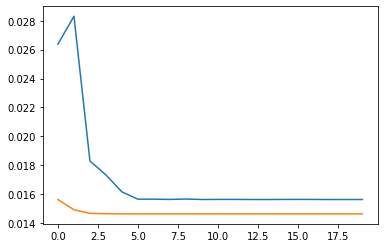

In [459]:
plt.plot(train_history)
plt.plot(val_history)

In [ ]:
###initialized Network
par_net_var = []
layers = [512, 4096, 4096, 4096, 8192, 4096, 2048, 2048, 256, 2048, 1]
 
par_net_var.append(layers)
act_funs = ['leaky', 'leaky', 'relu', 'relu', 'relu', 'tanh', 'relu', 'relu', 'elu', 'leaky', 'leaky']
par_net_var.append(act_funs)
model = NN2(input_dim, par_net_var[0], par_net_var[1])
model.to(device)
par_score = train_and_eval(model)
epoch_train = 1000000
init_mut_rate = 0.2
#Parameters boundaries
min_lay = 4
max_lay = 20
min_neuron = 8
max_neuron = 8192
options_act = ['relu','elu','leaky','tanh']

score_history = []
for i in range(0,epoch_train):
    par_net_var, par_score = mutate_and_selection(par_net_var,par_score,init_mut_rate)
    score_history.append(par_score)
    if(np.mod(i,5)==0):
        print(i)
print(par_net_var)



In [ ]:
#plot progression
print(score_history)
x = np.arange(1,len(score_history)+1)
plt.plot(x,score_history)
plt.xlabel('Training sessions') 
plt.ylabel('Validation Score') 
plt.title('Progression of EA')
plt.show()


In [460]:
#torch.save(model.state_dict(), 'drive/My Drive/Valid_Data/model6-12%.pkl')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

#X = test_dataset[:][0].cpu().detach().numpy()

# Make predictions and get the targets
model.eval()
predictions = model(test_dataset[:][0].to(device)).cpu().detach().numpy()
target = test_dataset[:][1].to(device).cpu().detach().numpy()
print(mean_squared_error(target, predictions))
# Transform back into scale
unscaled_predictions = y_scaler.inverse_transform(predictions)
unscaled_target = y_scaler.inverse_transform(target.reshape(-1,1))

MAE = mean_absolute_error(unscaled_target, unscaled_predictions)
MSE = mean_squared_error(unscaled_target, unscaled_predictions)
print(f'MAE of test set: {MAE}')
print(f'MSE of test set: {MSE}')
print(f'R^2 score: {r2_score(unscaled_target, unscaled_predictions)}' )
print(f'Explained Variance: {explained_variance_score(unscaled_target, unscaled_predictions)}')

test_loss = test()
print(f'Test Loss: {test_loss:.4e}')
print(f'Percentage we are off on average based on MAE: {MAE/np.mean(unscaled_target):.4e}')



1.1810242
MAE of test set: 0.48927590250968933
MSE of test set: 1.181024193763733
R^2 score: -0.0005325552851402904
Explained Variance: 0.0002053380012512207


C:\Users\niskl\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\niskl\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 2.9592e+01
Percentage we are off on average based on MAE: 1.5849e+01


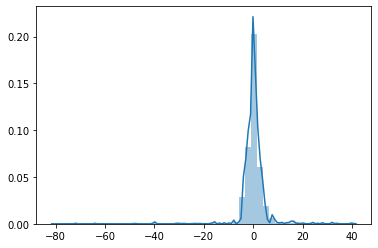

In [391]:
sns.distplot(unscaled_target - test_target.reshape(-1,1))

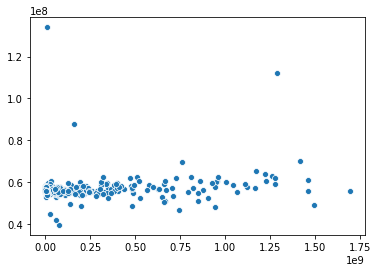

In [389]:
#print(unscaled_target.shape)
#print(unscaled_predictions.shape)

sns.scatterplot(unscaled_target.flatten(),unscaled_predictions.flatten())

In [0]:
  i=0
  j=0
  #print(saved_target.values)
  for targ in unscaled_target:
    c= sum(saved_target.values==targ)
    if(c==1): i=i+1
    if(c>1): 
      print(targ)
      print(df[df.Revenue==targ].cvrNummer)
      print(saved_target.values[saved_target.values==targ])
    j = j+1


print(i/len(unscaled_target))
print(j/len(unscaled_target))
print(len(unscaled_target))
print(len(saved_target.values))

In [0]:
df[df.Revenue==61805000].cvrNummer

In [0]:
sns.distplot(unscaled_predictions)
sns.distplot(unscaled_target)

In [0]:
from tabulate import tabulate

def latex_architecture(latex,enc_name,enc,scl_name,scl,opt_name,opt,crit,rm_pol,mod,sc):
  if(latex):
    def print_func(x):print(tabulate(x, tablefmt="latex_raw"))
  else:
    def print_func(x): 
      for el in x: print(el)
      print("")
  table = [["Encoder Attributes:", ""],
           ["Encoder",enc_name]]
  pars = list(encoder.get_params())[1:-1]
  for par in pars: table.extend([[par,encoder.get_params()[par]]])
  print_func(table)
  #print(print_func(table))
  #if(latex):print(tabulate(table, tablefmt="latex_raw"))
  #else: print(table)
  table = [["scaler attributes", ""],
           ["Scaler",scl_name]]
  pars = list(scl.get_params())
  for par in pars: table.extend([[par,scl.get_params()[par]]])
  print_func(table)
  
  #removal policy
  print_func(rm_pol)#print(tabulate(rm_pol, tablefmt="latex_raw"))
  #optimizer
  table = [["Optimizer attributes:", ""],
           ["Optimizer",opt_name]]
  attr = opt.defaults
  for att in attr: table.extend([[att,opt.defaults[att]]]) 
  print_func(table)
  #print(tabulate(table, tablefmt="latex_raw"))

  #criterion
  table = [["Criterion atttributes:", ""],
           ["Loss function",crit]]
  print_func(table)
  #model architecture
  layers = mod._modules.items()
  table = [["Layers:"]]
  for layer in layers: table.extend([[layer[1]]])
  
  #print(tabulate(table, tablefmt="latex_raw"))
  print_func(table)
  #score
  #print(tabulate(sc, tablefmt="latex_raw"))
  print_func(sc)
  

  return()
removal_policy = [['Data Removal:'],['Keep only newest instance'],['All columns that sum to zero'],
                  ['All attributes with "date"'],
                  ['Attribute AARSRAPPORT_pdf'],
                  ['Attribute AARSRAPPORT_html'],
                  ['Attribute AARSRAPPORT_xml'],
                  ['Attribute _score'],
                  ['Attribute entity'],
                  ['Attribute cvrNummer'],
                  ['Attribute regnskabsperiode_startDato'],
                  ['Attribute sidstOpdateret'],
                  ['Attribute sagsNummer'],
                  ['Attribute regnskabsperiode_slutDato'],
                  ['Attribute _index'],
                  ['Attribute context'],
                  ['Attribute end_date'],
                  ['Attribute offentliggoerelsesTidspunkt'],
                  ['Attribute indlaesningsTidspunkt'],
                  ['Attribute indlaesningsId'],
                  ['Attribute _id'],
                  ['Attribute regNummer'],
                  ['All companies with target <=0'],
                  ['All companies with revenue <=0']]
score = [['Score:',""],['MAE',MAE],
         ['R2',r2_score(unscaled_target, unscaled_predictions)],
         ['Explained Variance', explained_variance_score(unscaled_target, unscaled_predictions)],
         ['MAE adjusted for mean',MAE/np.mean(unscaled_target)]
         ]
latex_architecture(latex=True,enc_name="Target Encoder",enc=encoder,scl_name='X_scaler',scl=X_scaler,
                   opt_name="Adam",opt=optimizer,rm_pol=removal_policy,mod=model, crit=criterion,
                   sc=score)

SyntaxError: ignored